In [55]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn 
import torch.optim as optim 
import torchvision.datasets as dset

import torchvision.transforms as transforms 
import torchvision.utils as utils


In [56]:
output_size = 64 
noise_size = 100 
batch_size = 128
leaky_slope = 0.02

w_mean = 0.0 
w_std = 0.2

lr = 0.0002
beta1 = 0.5

ngf = 64
ndf = 64

In [57]:
DATA_DIR = "data/"

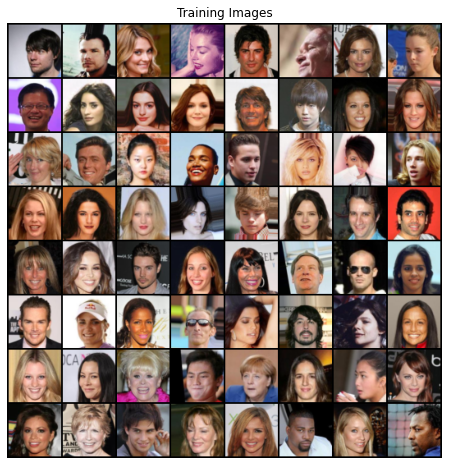

In [63]:
dataset = dset.ImageFolder(root=DATA_DIR,
                           transform=transforms.Compose([
                               transforms.Resize(output_size),
                               transforms.CenterCrop(output_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [64]:
dataset = torch.utils.data.DataLoader(
    dataset, 
    batch_size=batch_size,
    shuffle=True, 
    num_workers=4, 
    drop_last=True
)

In [65]:
def plot_grid(grid): 
    plt.figure(figsize=(10,10))
    inp = np.transpose(grid, (1,2,0))
    plt.imshow(inp) 
    plt.show()

In [66]:
data = iter(dataset) 
inputs, _ = data.next()

grid = torchvision.utils.make_grid(inputs, padding=2, normalize=True) 

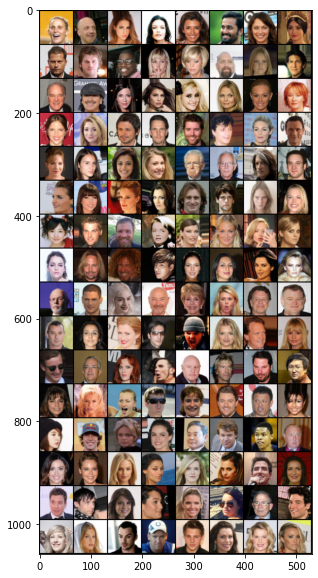

In [67]:
plot_grid(grid)

In [68]:
def weights_init(m):

    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight.data, w_mean, w_std)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, w_mean, w_std)
        nn.init.normal_(m.bias.data, 0)
        


In [69]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( noise_size, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state False. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
    
    
generator = Generator()
generator.to(device)
generator.apply(weights_init)


from torchsummary import summary

summary(generator, input_size=(100,1, 1), batch_size=1, device="cuda")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1             [1, 512, 4, 4]         819,200
       BatchNorm2d-2             [1, 512, 4, 4]           1,024
              ReLU-3             [1, 512, 4, 4]               0
   ConvTranspose2d-4             [1, 256, 8, 8]       2,097,152
       BatchNorm2d-5             [1, 256, 8, 8]             512
              ReLU-6             [1, 256, 8, 8]               0
   ConvTranspose2d-7           [1, 128, 16, 16]         524,288
       BatchNorm2d-8           [1, 128, 16, 16]             256
              ReLU-9           [1, 128, 16, 16]               0
  ConvTranspose2d-10            [1, 64, 32, 32]         131,072
      BatchNorm2d-11            [1, 64, 32, 32]             128
             ReLU-12            [1, 64, 32, 32]               0
  ConvTranspose2d-13             [1, 3, 64, 64]           3,072
             Tanh-14             [1, 3,

In [70]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    

discriminator = Discriminator()
discriminator.to(device)
discriminator.apply(weights_init)
summary(discriminator, input_size=(3, 64, 64), batch_size=1, device="cuda")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 64, 32, 32]           3,072
         LeakyReLU-2            [1, 64, 32, 32]               0
            Conv2d-3           [1, 128, 16, 16]         131,072
       BatchNorm2d-4           [1, 128, 16, 16]             256
         LeakyReLU-5           [1, 128, 16, 16]               0
            Conv2d-6             [1, 256, 8, 8]         524,288
       BatchNorm2d-7             [1, 256, 8, 8]             512
         LeakyReLU-8             [1, 256, 8, 8]               0
            Conv2d-9             [1, 512, 4, 4]       2,097,152
      BatchNorm2d-10             [1, 512, 4, 4]           1,024
        LeakyReLU-11             [1, 512, 4, 4]               0
           Conv2d-12               [1, 1, 1, 1]           8,192
          Sigmoid-13               [1, 1, 1, 1]               0
Total params: 2,765,568
Trainable param

In [71]:
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, noise_size, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

In [72]:
torch.autograd.set_detect_anomaly(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/1][0/1059]	Loss_D: 0.0708	Loss_G: 3.9713	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


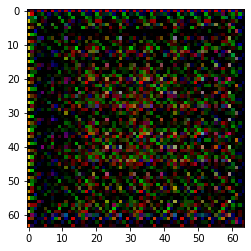

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/1][50/1059]	Loss_D: 0.0589	Loss_G: 4.5676	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


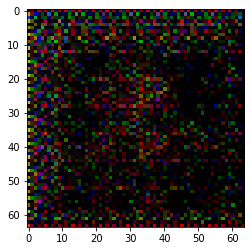

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/1][100/1059]	Loss_D: 0.0397	Loss_G: 4.5356	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


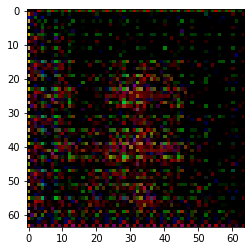

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/1][150/1059]	Loss_D: 0.0150	Loss_G: 2.6920	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


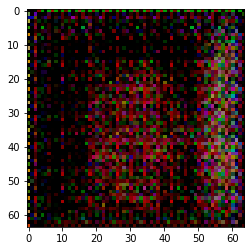

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/1][200/1059]	Loss_D: 0.0804	Loss_G: 4.2915	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


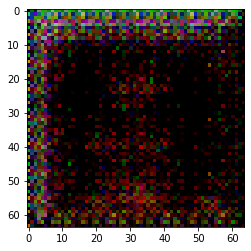

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/1][250/1059]	Loss_D: 0.0248	Loss_G: 4.0290	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


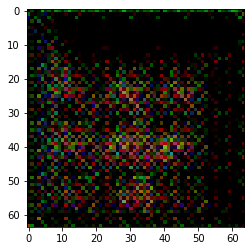

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/1][300/1059]	Loss_D: 0.4207	Loss_G: 3.1480	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


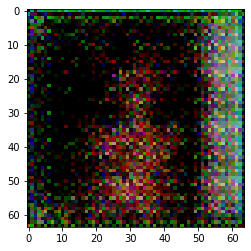

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/1][350/1059]	Loss_D: 0.0758	Loss_G: 12.8121	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


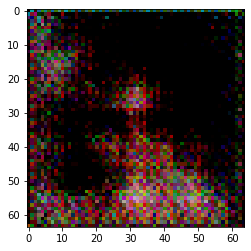

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/1][400/1059]	Loss_D: 0.1347	Loss_G: 3.4955	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


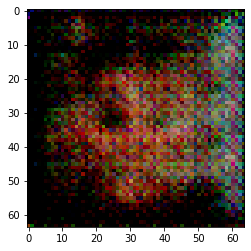

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/1][450/1059]	Loss_D: 0.1562	Loss_G: 3.1118	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


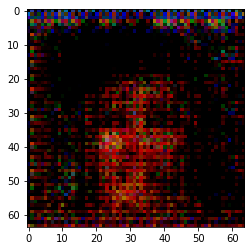

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/1][500/1059]	Loss_D: 0.1359	Loss_G: 3.2969	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


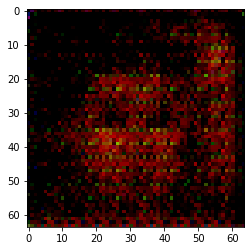

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/1][550/1059]	Loss_D: 0.1805	Loss_G: 2.7663	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


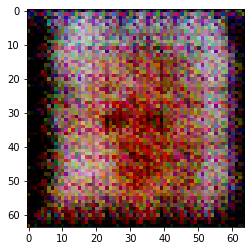

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/1][600/1059]	Loss_D: 0.1039	Loss_G: 3.9233	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


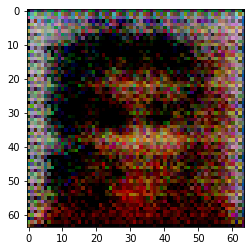

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/1][650/1059]	Loss_D: 0.0917	Loss_G: 4.4785	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


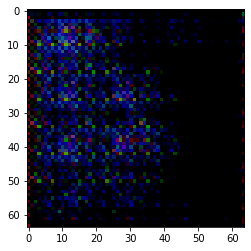

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/1][700/1059]	Loss_D: 0.1297	Loss_G: 3.5143	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


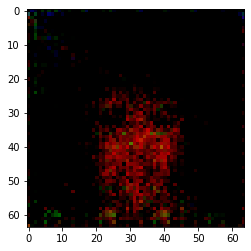

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/1][750/1059]	Loss_D: 0.1040	Loss_G: 3.4298	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


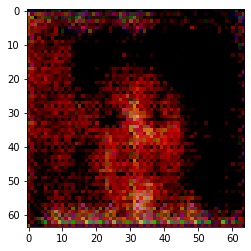

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/1][800/1059]	Loss_D: 0.0498	Loss_G: 3.2780	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


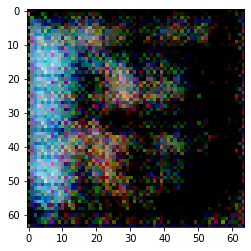

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/1][850/1059]	Loss_D: 0.6862	Loss_G: 7.9692	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


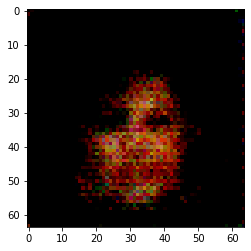

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/1][900/1059]	Loss_D: 0.3734	Loss_G: 3.5756	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


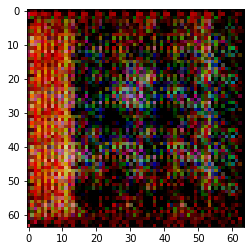

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/1][950/1059]	Loss_D: 0.1627	Loss_G: 3.3592	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


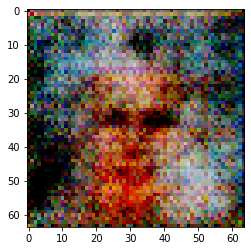

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/1][1000/1059]	Loss_D: 0.1269	Loss_G: 6.3522	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


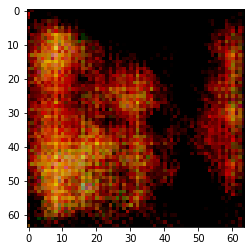

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/1][1050/1059]	Loss_D: 0.3427	Loss_G: 2.5686	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


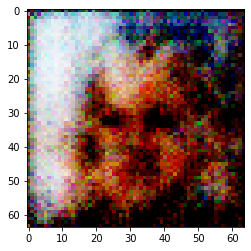

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/1][0/1059]	Loss_D: 0.4311	Loss_G: 1.7345	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


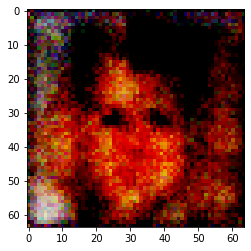

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/1][50/1059]	Loss_D: 0.3790	Loss_G: 1.8842	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


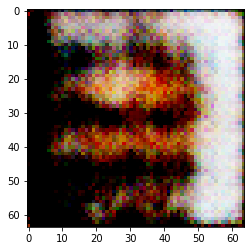

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/1][100/1059]	Loss_D: 0.4371	Loss_G: 4.4824	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


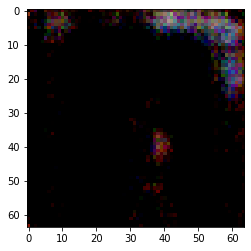

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/1][150/1059]	Loss_D: 0.1646	Loss_G: 3.5577	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


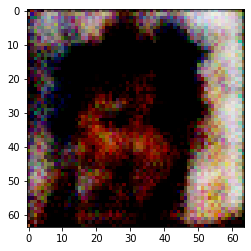

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/1][200/1059]	Loss_D: 0.1520	Loss_G: 3.6454	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


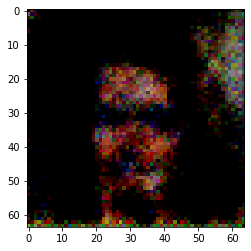

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/1][250/1059]	Loss_D: 0.6808	Loss_G: 2.1318	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


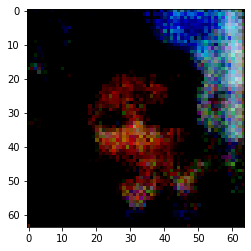

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/1][300/1059]	Loss_D: 0.4432	Loss_G: 4.9358	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


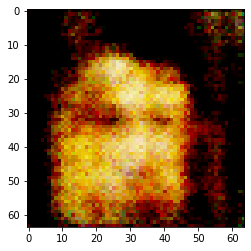

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/1][350/1059]	Loss_D: 0.1583	Loss_G: 4.0955	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


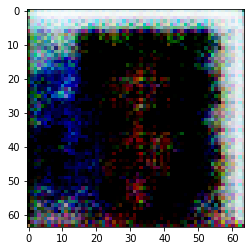

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/1][400/1059]	Loss_D: 0.2970	Loss_G: 4.0468	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


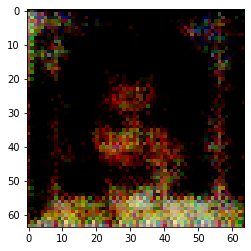

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/1][450/1059]	Loss_D: 0.1582	Loss_G: 2.8521	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


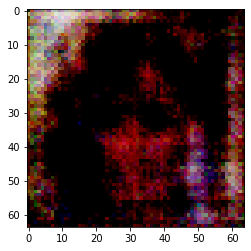

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/1][500/1059]	Loss_D: 0.8079	Loss_G: 5.5297	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


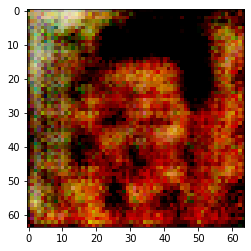

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/1][550/1059]	Loss_D: 1.5113	Loss_G: 0.8356	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


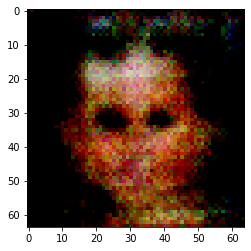

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/1][600/1059]	Loss_D: 0.1234	Loss_G: 3.8699	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


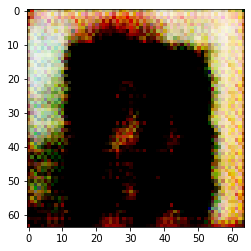

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/1][650/1059]	Loss_D: 0.3730	Loss_G: 3.9946	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


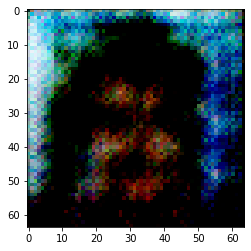

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/1][700/1059]	Loss_D: 0.3455	Loss_G: 2.6359	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


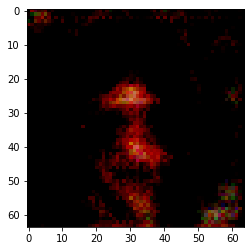

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/1][750/1059]	Loss_D: 0.9987	Loss_G: 2.0135	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


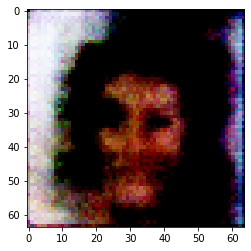

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/1][800/1059]	Loss_D: 0.8649	Loss_G: 3.8571	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


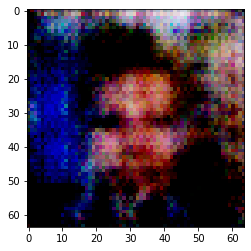

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/1][850/1059]	Loss_D: 0.5280	Loss_G: 5.1880	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


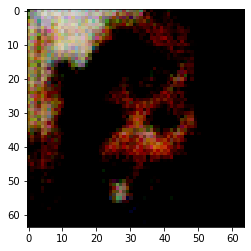

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/1][900/1059]	Loss_D: 0.4083	Loss_G: 2.0733	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


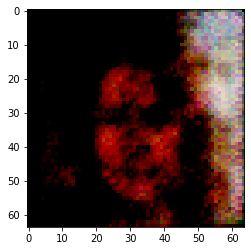

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/1][950/1059]	Loss_D: 0.2709	Loss_G: 2.4761	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


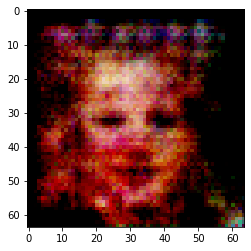

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/1][1000/1059]	Loss_D: 0.2743	Loss_G: 3.8718	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


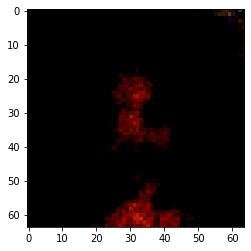

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/1][1050/1059]	Loss_D: 0.3592	Loss_G: 3.7062	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


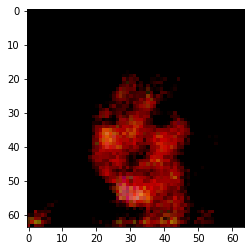

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2/1][0/1059]	Loss_D: 0.2952	Loss_G: 2.8137	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


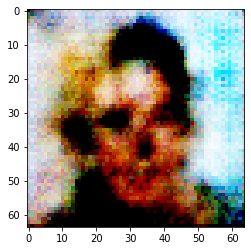

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2/1][50/1059]	Loss_D: 0.3237	Loss_G: 2.9035	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


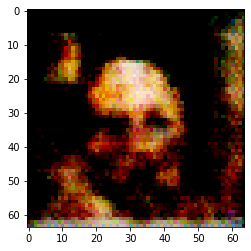

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2/1][100/1059]	Loss_D: 0.3293	Loss_G: 3.9502	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


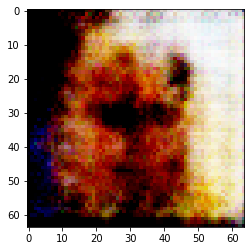

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2/1][150/1059]	Loss_D: 0.4480	Loss_G: 0.9060	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


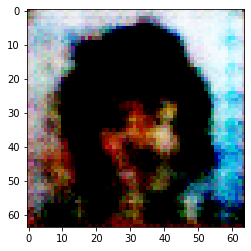

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2/1][200/1059]	Loss_D: 0.1999	Loss_G: 3.1791	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


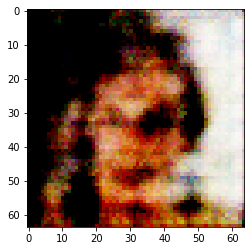

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2/1][250/1059]	Loss_D: 0.5059	Loss_G: 4.2941	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


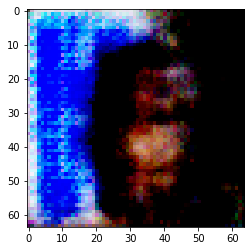

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2/1][300/1059]	Loss_D: 0.2884	Loss_G: 4.1761	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


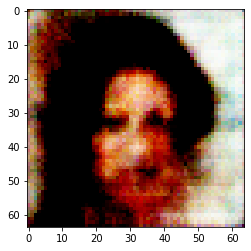

KeyboardInterrupt: 

In [75]:
errG = 0.0
errD = 0.0

for epoch in range(10):
    # For each batch in the dataloader
    for i, data in enumerate(dataset, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator.zero_grad()
        # Format batch
        real_cpu, _ = data
        real_cpu = real_cpu.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = discriminator(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(batch_size, noise_size, 1, 1, device=device)
        # Generate fake image batch with G
        fake = generator(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = discriminator(fake.detach()).view(-1)
        
        
        
        
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        
        if i % 50 == 0:
            D_x = 1
            D_G_z1 = 1
            D_G_z2 = 1
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, 1, i, len(dataset),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            plt.imshow(np.transpose(fake.detach().cpu().numpy()[0], [1, 2, 0]))
            plt.show()
        

        